In [18]:
import cv2
import math
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import random
import argparse
import uuid

# Argparse

In [24]:
parser = argparse.ArgumentParser()

parser.add_argument('--load', required=True, type=Path)
parser.add_argument('--save', required=True, type=Path)
parser.add_argument('-r', action='count', default=0)
parser.add_argument('-t', action='store_true')
parser.add_argument('-g', action='store_true')
parser.add_argument('-s', action='store_true')
parser.add_argument('-b', action='store_true')

parser.parse_args(['--load', '.', '--save', '.'])

Namespace(b=False, g=False, load=PosixPath('.'), r=0, s=False, save=PosixPath('.'), t=False)

# Folders and files  

In [13]:
def read_labels(file):
    return np.loadtxt(file, delimiter=' ', unpack=False)


def save_labels(file, labels):
    return np.savetxt(file, labels, delimiter=' ', unpack=False)


def get_paths(path):
    p = Path(path).glob("*")
    return [x for x in p if x.is_file()]


def save_images(original_image, image_with_boxes):
    images_path = Path('inference/original')
    output_path = Path('inference/recognized')
    images_path.mkdir(parents=True, exist_ok=True)
    output_path.mkdir(parents=True, exist_ok=True)

    identifier = str(uuid.uuid4()).replace('-', '_')
    images_path = str(images_path / f'{identifier}.jpg')
    output_path = str(output_path / f'{identifier}.jpg')

    cv2.imwrite(images_path, original_image)
    cv2.imwrite(output_path, image_with_boxes)

    return images_path, output_path

In [14]:
get_paths('')

[PosixPath('.gitignore'),
 PosixPath('README.md'),
 PosixPath('research.ipynb'),
 PosixPath('requirements.txt')]

# Transform YOLOv5's notes 

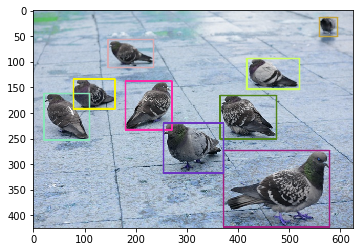

In [12]:
def plot_rectangle(x, img):
    tl = round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1
    color = [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int((x[0] - x[2] / 2) * img.shape[1]), int((x[1] - x[3] / 2) * img.shape[0])), (int((x[0] + x[2] / 2) * img.shape[1]), int((x[1] + x[3] / 2) * img.shape[0]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    
    
def draw_rectangles(image, labels):
    tmp = image.copy()
    for label in labels:
        plot_rectangle(label[1:], tmp)
    return tmp
    
    
labels = read_labels('data/labels/dove.txt')
image = cv2.imread('data/images/dove.jpg')
boxed_image = draw_rectangles(image, labels)

plt.imshow(boxed_image)

# Image level augmentation

### Original image

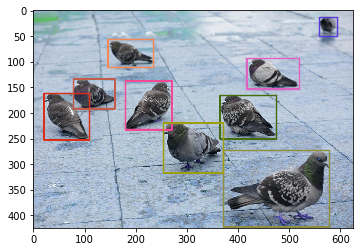

In [13]:
boxed_image = draw_rectangles(image, labels)
plt.imshow(boxed_image)

### Rotated image

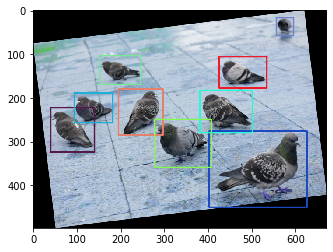

In [54]:
def from_yolo(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H

    voc = []

    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))

    return [int(v) for v in voc]


def to_yolo(corner, H, W):
    bbox_W = corner[3] - corner[1]
    bbox_H = corner[4] - corner[2]

    center_bbox_x = (corner[1] + corner[3]) / 2
    center_bbox_y = (corner[2] + corner[4]) / 2

    return corner[0], round(center_bbox_x / W, 6), round(center_bbox_y / H, 6), round(bbox_W / W, 6), round(bbox_H / H,
                                                                                                            6)

def rotate_labels(labels, rotation_angle, image, rotated_image):
    new_height, new_width = rotated_image.shape[:2]
    rotation_angle = math.radians(rotation_angle)
    rot_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])

    new_bbox = []
    

    H, W = image.shape[:2]

    for bbox in labels:
        if len(bbox) > 1:
            (center_x, center_y, bbox_width, bbox_height) = from_yolo(float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]), H, W)

            upper_left_corner_shift = (center_x - W / 2, -H / 2 + center_y)
            upper_right_corner_shift = (bbox_width - W / 2, -H / 2 + center_y)
            lower_left_corner_shift = (center_x - W / 2, -H / 2 + bbox_height)
            lower_right_corner_shift = (bbox_width - W / 2, -H / 2 + bbox_height)

            new_lower_right_corner = [-1, -1]
            new_upper_left_corner = []

            for i in (upper_left_corner_shift, upper_right_corner_shift, lower_left_corner_shift,
                      lower_right_corner_shift):
                new_coords = np.matmul(rot_matrix, np.array((i[0], -i[1])))
                x_prime, y_prime = new_width / 2 + new_coords[0], new_height / 2 - new_coords[1]
                if new_lower_right_corner[0] < x_prime:
                    new_lower_right_corner[0] = x_prime
                if new_lower_right_corner[1] < y_prime:
                    new_lower_right_corner[1] = y_prime

                if len(new_upper_left_corner) > 0:
                    if new_upper_left_corner[0] > x_prime:
                        new_upper_left_corner[0] = x_prime
                    if new_upper_left_corner[1] > y_prime:
                        new_upper_left_corner[1] = y_prime
                else:
                    new_upper_left_corner.append(x_prime)
                    new_upper_left_corner.append(y_prime)

            new_bbox.append(to_yolo([bbox[0], new_upper_left_corner[0], new_upper_left_corner[1], new_lower_right_corner[0], new_lower_right_corner[1]], new_height, new_width))
    
    return np.array(new_bbox)


def rotate_image(image, angleInDegrees):
    h, w = image.shape[:2]
    img_c = (w / 2, h / 2)

    rot = cv2.getRotationMatrix2D(img_c, angleInDegrees, 1)

    rad = math.radians(angleInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))
    
    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])
    
    outImg = cv2.warpAffine(image, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
    return outImg

angle = random.randint(5, 50)
rotated_image = rotate_image(image, angle)
rotated_labels = rotate_labels(labels, angle, image, rotated_image)
boxed_image = draw_rectangles(rotated_image, rotated_labels)
plt.imshow(boxed_image)

### Grayscale image

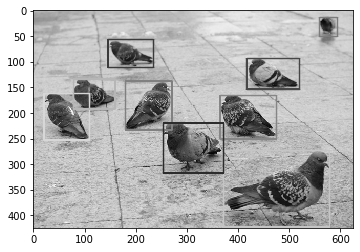

In [15]:
def image_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


boxed_image = draw_rectangles(image_to_grayscale(image), labels)

plt.imshow(boxed_image, cmap='gray')

### 90deg rotated image

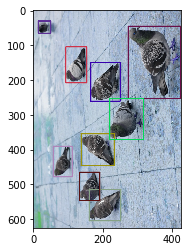

In [58]:
rotated_image = rotate_image(image, 90)
rotated_labels = rotate_labels(labels, 90, image, rotated_image)
boxed_image = draw_rectangles(rotated_image, rotated_labels)
plt.imshow(boxed_image)

### 180deg rotated image


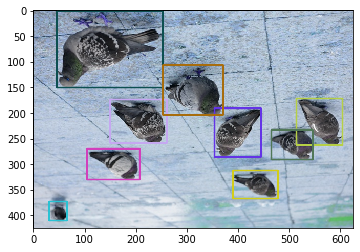

In [59]:
rotated_image = rotate_image(image, 180)
rotated_labels = rotate_labels(labels, 180, image, rotated_image)
boxed_image = draw_rectangles(rotated_image, rotated_labels)
plt.imshow(boxed_image)

### 270deg rotated image

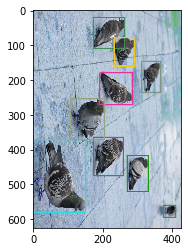

In [60]:
rotated_image = rotate_image(image, 270)
rotated_labels = rotate_labels(labels, 270, image, rotated_image)
boxed_image = draw_rectangles(rotated_image, rotated_labels)
plt.imshow(boxed_image)

### Salt-and-pepper noisy image

/home/happy-unicorn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/happy-unicorn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


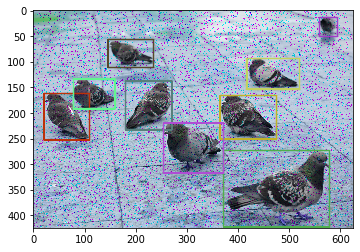

In [17]:
def noisy(image):
    row, col, ch = image.shape
    s_vs_p = 0.5
    amount = 0.04
    out = image.copy()
    
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    
    return out

boxed_image = draw_rectangles(noisy(image), labels)
plt.imshow(boxed_image)

### Blured image

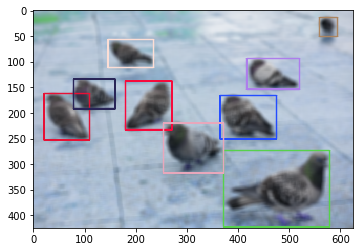

In [16]:
def blur(image):
    ksize = (10, 10)
    return cv2.blur(image, ksize)
    
    
boxed_image = draw_rectangles(blur(image), labels)
plt.imshow(boxed_image)